<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Interpretation4_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the first dataset

We first need to load the dataset. 

In [1]:
#@title
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

torch.manual_seed(0)

dtype = torch.float

FIGSIZE = (6,5)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
  Created wheel for flashtorch: filename=flashtorch-0.1.2-cp36-none-any.whl size=26236 sha256=97512fddc86540b7f8e4d229e741f898ed0eda502b5d15e5a8c37b659da4f396
  Stored in directory: /root/.cache/pip/wheels/91/44/8e/c33cc10ab8d0f24036e82f0e475277dc4a479cd3fb03329a39
Successfully built flashtorch
     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383178 sha256=d5b31e10cbfa85807b

Now, we need to redefine the model, so that we can compute a saliency map for an input image. Then, we also want to load the state_dict of the trained model. 

In [2]:
#@title
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 4)
    self.pool2 = nn.MaxPool2d(kernel_size = 5)
    self.fc1 = nn.Linear(in_features = 16*9*11, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 84)
    self.fc3 = nn.Linear(in_features = 84, out_features = 2)
    self.drop = nn.Dropout(p = 0.5)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model4_random.pth')) 

<All keys matched successfully>

Now, load and format the images we want to test the network's decision on. 

In [0]:
#@title
transf = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

im = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/random_4", transform = transf)
batch_Size = 3
dataloader = DataLoader(im, batch_size = batch_Size, shuffle = False, num_workers = 0)
data = iter(dataloader)
images, labels = next(data)

idx_to_class = {j:i for i,j in im.class_to_idx.items()}

For this dataset, we should import two images with label 0, because a label 0 can be attributed for two different reasons: 
- absence of a black circle 
- presence of a cross 

Let's first do one with crosses. 

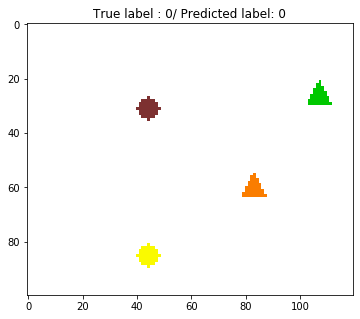

In [4]:
#@title
image0 = images[0]
label0 = labels[0]

im0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 

outputs = net(im0)

_, predicted0 = torch.max(outputs.data, 1)

def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  sample_image = image.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  im = sample_image*sd + mean
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[int(true_label)]
  
  if (predicted_label != None):
    title_ += "/ Predicted label: " + idx_to_class[predicted_label]

  plt.title(title_)

display_image(image0, label0, int(predicted0))

This image was correctly labeled as a 0, because it contains crosses (even though there is a black circle). 

What parts in the input were considered important by the network to make this call ? 

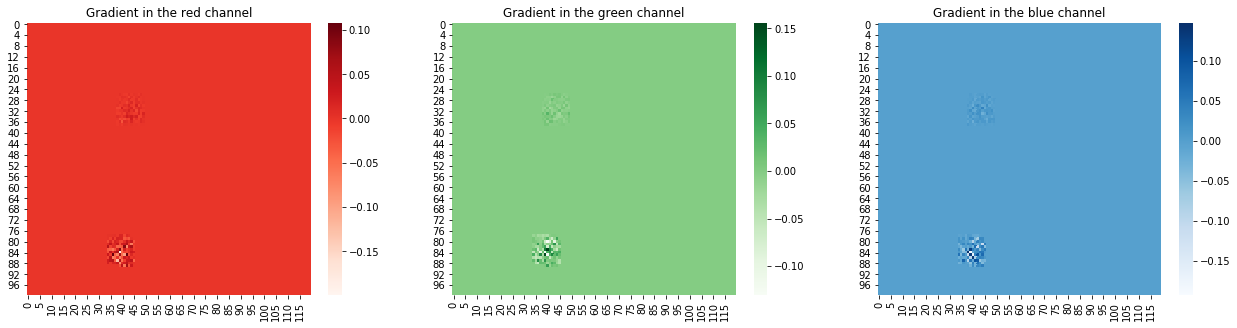

In [5]:
#@title
im0.requires_grad = True # Otherwise we can't compute the gradient 
backprop = Backprop(net)
gradients0 = backprop.calculate_gradients(im0, label0)

fig = plt.figure(figsize = (3*FIGSIZE[0]*1.2, FIGSIZE[1]))
ax1 = fig.add_subplot(131, title = "Gradient in the red channel")
ax2 = fig.add_subplot(132, title = "Gradient in the green channel")
ax3 = fig.add_subplot(133, title = "Gradient in the blue channel")
_ = sns.heatmap(gradients0.detach().numpy()[0], cmap="Reds", ax = ax1)
_ = sns.heatmap(gradients0.detach().numpy()[1], cmap="Greens", ax = ax2)
_ = sns.heatmap(gradients0.detach().numpy()[2], cmap="Blues", ax = ax3)

Crosses and the black circle are most relevant, but the input region of the grey square also seems to matter. There is no color dependence, since black depends as much on the value of each channel. 

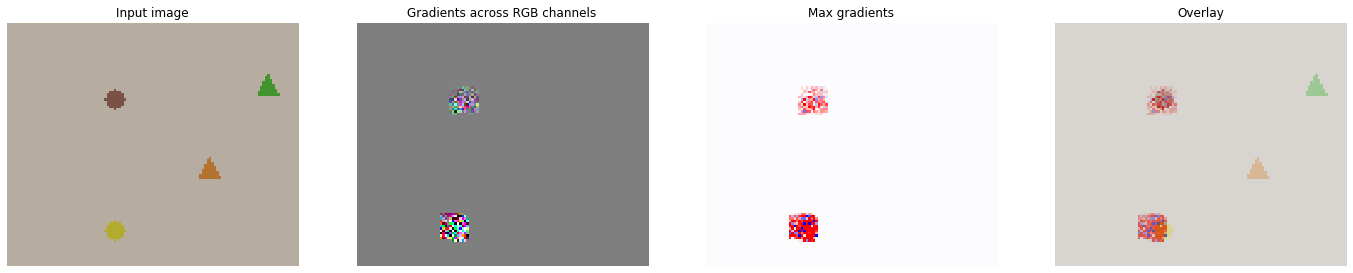

In [6]:
#@title
backprop.visualize(im0, label0, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

Now, one with no black circles.

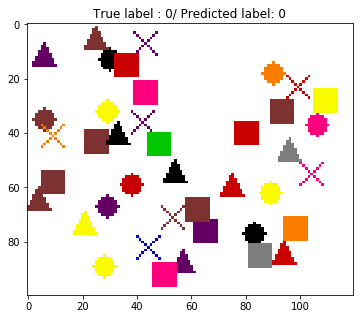

In [7]:
#@title
image1 = images[1]
label1 = labels[1]

im1 = image1.view(-1, 3, 100, 120) # This shape is necessary for the network 

outputs = net(im1)

_, predicted1 = torch.max(outputs.data, 1)

display_image(image1, label1, int(predicted1))

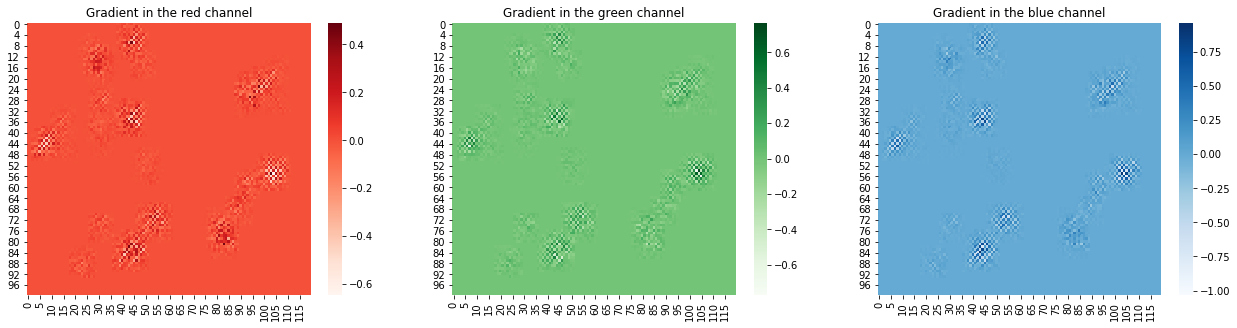

In [8]:
#@title
im1.requires_grad = True # Otherwise we can't compute the gradient 
backprop = Backprop(net)
gradients1 = backprop.calculate_gradients(im1, label1)

fig = plt.figure(figsize = (3*FIGSIZE[0]*1.2, FIGSIZE[1]))
ax1 = fig.add_subplot(131, title = "Gradient in the red channel")
ax2 = fig.add_subplot(132, title = "Gradient in the green channel")
ax3 = fig.add_subplot(133, title = "Gradient in the blue channel")
_ = sns.heatmap(gradients1.detach().numpy()[0], cmap="Reds", ax = ax1)
_ = sns.heatmap(gradients1.detach().numpy()[1], cmap="Greens", ax = ax2)
_ = sns.heatmap(gradients1.detach().numpy()[2], cmap="Blues", ax = ax3)

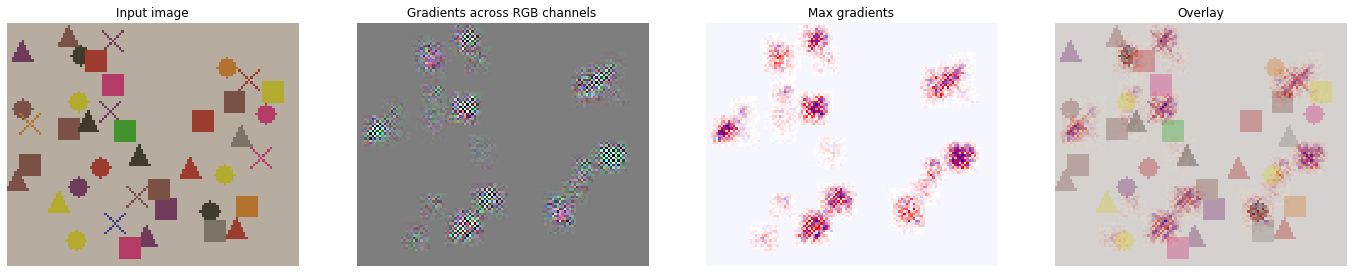

In [9]:
#@title
backprop.visualize(im1, label1, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

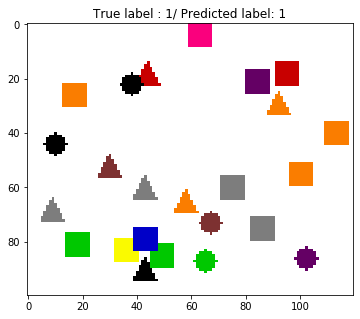

In [10]:
#@title
image2 = images[2]
label2 = labels[2]

im2 = image2.view(-1, 3, 100, 120)
outputs = net(im2)
_, predicted2 = torch.max(outputs.data, 1)

display_image(image2, label2, int(predicted2))

This image was correctly labeled as a 1, because it contains a black circle but no crosses.

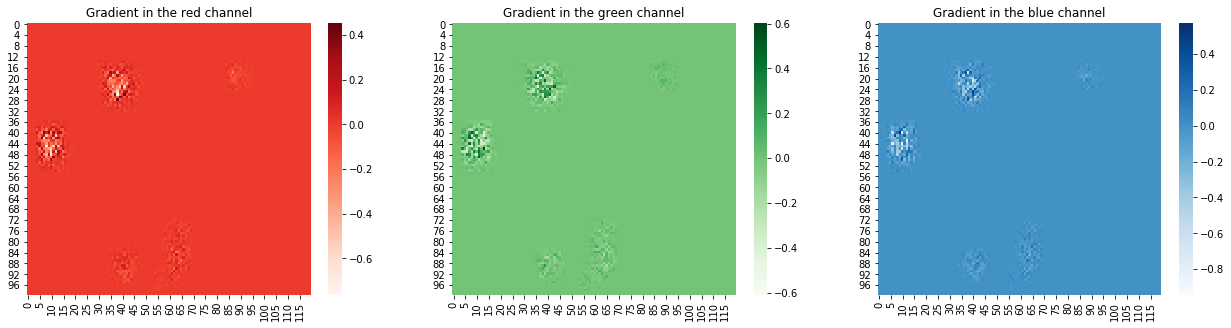

In [11]:
#@title
im2.requires_grad = True # Necessary to compute the gradient
gradients2 = backprop.calculate_gradients(im2, label2)

fig = plt.figure(figsize = (3*FIGSIZE[0]*1.2, FIGSIZE[1]))
ax1 = fig.add_subplot(131, title = "Gradient in the red channel")
ax2 = fig.add_subplot(132, title = "Gradient in the green channel")
ax3 = fig.add_subplot(133, title = "Gradient in the blue channel")
_ = sns.heatmap(gradients2.detach().numpy()[0], cmap="Reds", ax = ax1)
_ = sns.heatmap(gradients2.detach().numpy()[1], cmap="Greens", ax = ax2)
_ = sns.heatmap(gradients2.detach().numpy()[2], cmap="Blues", ax = ax3)

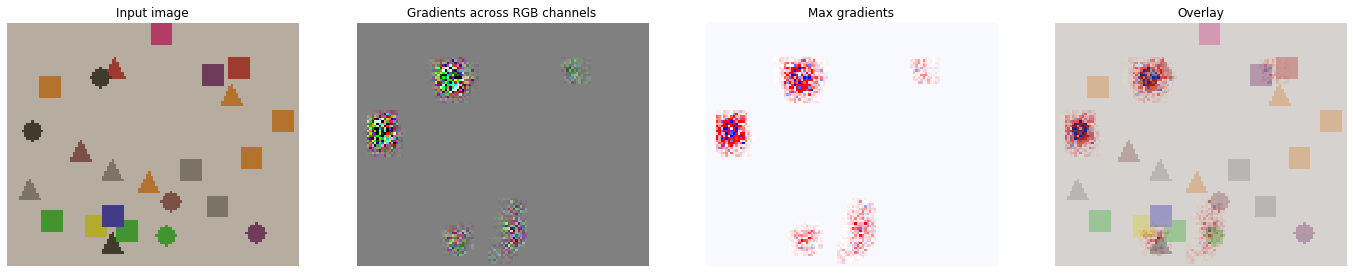

In [12]:
#@title
backprop.visualize(im2, label2, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap = 'bwr')

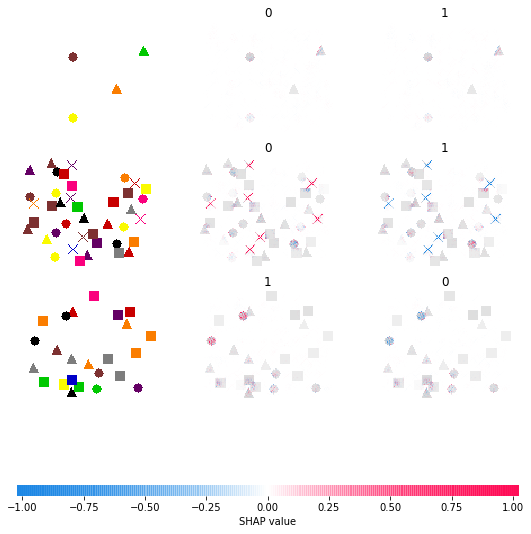

In [13]:
#@title
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/3000/data4/random.zip", 'r')

bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = len(train_data), shuffle = False, num_workers = 0)

train_loader = iter(dataloader)
X,Y = next(train_loader)
background = X

if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)
  background = avg.unsqueeze(0)

to_explain = images

e = shap.GradientExplainer(net, background)

shap_values,indexes = e.shap_values(to_explain, ranked_outputs=2, nsamples=200)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]


to_explain = np.swapaxes(np.swapaxes(to_explain,1,2),2,3)



mean = np.array([0.5, 0.5, 0.5])
sd = np.array([0.5, 0.5, 0.5])
images_plot = 255*(to_explain.numpy()*0.5 + 0.5)


shap.image_plot(shap_values, images_plot, indexes.numpy())